# Interacting with CLIP

This is a self-contained notebook that shows how to download and run CLIP models, calculate the similarity between arbitrary image and text inputs, and perform zero-shot image classifications.

# Preparation for Colab

Make sure you're running a GPU runtime; if not, select "GPU" as the hardware accelerator in Runtime > Change Runtime Type in the menu. The next cells will install the `clip` package and its dependencies, and check if PyTorch 1.7.1 or later is installed.

In [6]:
# ! pip install ftfy regex tqdm
# ! pip install git+https://github.com/openai/CLIP.git

# ! pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
# # (use --upgrade --force-reinstall to upgrade)

# ! pip install scikit-image
# ! pip install matplotlib
# ! pip install opencv-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB 1.8 MB/s eta 0:00:00
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-4megb1zb
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-4megb1zb
  Resolved https://github.com/openai/CLIP.git to commit a1d071733d7111c9c014f024669f959182114e33
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 20.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 26.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 16.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 657.6 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━

In [3]:
import numpy as np
import torch
from pkg_resources import packaging

print("Torch version:", torch.__version__)
print(torch. cuda. is_available())
print("CUDA version:", torch.version.cuda)

Torch version: 2.2.2+cu118
True
CUDA version: 11.8


# Loading the model

`clip.available_models()` will list the names of available CLIP models.

In [4]:
import clip

model, preprocess = clip.load("ViT-B/32")
model.cuda().eval()
input_resolution = model.visual.input_resolution
context_length = model.context_length
vocab_size = model.vocab_size

print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in model.parameters()]):,}")
print("Input resolution:", input_resolution)
print("Context length:", context_length)
print("Vocab size:", vocab_size)

Model parameters: 151,277,313
Input resolution: 224
Context length: 77
Vocab size: 49408


In [5]:
model, preprocess = clip.load("ViT-B/32")
model.cuda().eval()
input_resolution = model.visual.input_resolution
context_length = model.context_length
vocab_size = model.vocab_size

print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in model.parameters()]):,}")
print("Input resolution:", input_resolution)
print("Context length:", context_length)
print("Vocab size:", vocab_size)

Model parameters: 151,277,313
Input resolution: 224
Context length: 77
Vocab size: 49408


# Image Preprocessing

We resize the input images and center-crop them to conform with the image resolution that the model expects. Before doing so, we will normalize the pixel intensity using the dataset mean and standard deviation.

The second return value from `clip.load()` contains a torchvision `Transform` that performs this preprocessing.



In [6]:
preprocess

Compose(
    Resize(size=224, interpolation=bicubic, max_size=None, antialias=True)
    CenterCrop(size=(224, 224))
    <function _convert_image_to_rgb at 0x0000027D1B707E20>
    ToTensor()
    Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
)

# Text Preprocessing

We use a case-insensitive tokenizer, which can be invoked using `clip.tokenize()`. By default, the outputs are padded to become 77 tokens long, which is what the CLIP models expects.

In [ ]:
clip.tokenize("Hello World!")

tensor([[49406,  3306,  1002,   256, 49407,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0]], dtype=torch.int32)

# Setting up input images and texts

We are going to feed 8 example images and their textual descriptions to the model, and compare the similarity between the corresponding features.

The tokenizer is case-insensitive, and we can freely give any suitable textual descriptions.

In [14]:
import os
import skimage
import IPython.display
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

from collections import OrderedDict
import torch

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# images in skimage to use and their textual descriptions
descriptions = {
    "page": "a page of text about segmentation",
    "chelsea": "a facial photo of a tabby cat",
    "astronaut": "a portrait of an astronaut with the American flag",
    "rocket": "a rocket standing on a launchpad",
    "motorcycle_right": "a red motorcycle standing in a garage",
    "camera": "a person looking at a camera on a tripod",
    "horse": "a black-and-white silhouette of a horse",
    "coffee": "a cup of coffee on a saucer"
}

In [83]:
original_images = []
images = []
texts = []
plt.figure(figsize=(16, 5))

for filename in [filename for filename in os.listdir(skimage.data_dir) if filename.endswith(".png") or filename.endswith(".jpg")]:
    name = os.path.splitext(filename)[0]
    if name not in descriptions:
        continue

    image = Image.open(os.path.join(skimage.data_dir, filename)).convert("RGB")

    plt.subplot(2, 4, len(images) + 1)
    plt.imshow(image)
    plt.title(f"{filename}\n{descriptions[name]}")
    plt.xticks([])
    plt.yticks([])

    original_images.append(image)
    images.append(preprocess(image))
    texts.append(descriptions[name])

plt.tight_layout()


Output hidden; open in https://colab.research.google.com to view.

In [30]:
np.array(image).shape

(512, 512, 3)

### Video dataset example

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from torchvision.utils import save_image
import json

frame_types = ["frame_first", "frame_half", "frame_last", "comic_3", "comic_4"]

def vid_path(filename):
    return f'./data/video/train/{filename}'

def load_video(filename):
    cap = cv2.VideoCapture(filename)
    frames = []
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        frames.append(frame)
    cap.release()
    return np.array(frames)

def load_utt(vid_no, utt_no, text_data):
    utt = text_data[vid_no]['conversation'][utt_no-1]
    vid = load_video(vid_path(utt['video_name']))
    return vid, utt

def load_frame(fname, frame_type):
    path = f'./data/preproc/{frame_type}/{fname}.jpg'
    frame = cv2.imread(path)
    return frame

def frame_to_img(frame):
    # frame = Image.fromarray(frame).convert("RGB")
    # frame = Image.fromarray(np.array(frame)[:, :, ::-1])
    
    frame = Image.fromarray(frame[:, :, ::-1])
    return  frame

with open('data/Subtask_2_train.json') as f:
    text_data_list = json.load(f)
    # text data is a map of conversation id to conversation
    text_data = {text['conversation_ID']: text for text in text_data_list}

Sorry I am late , I was stuck at work . There was this big dinosaur ... thing ... anyway .


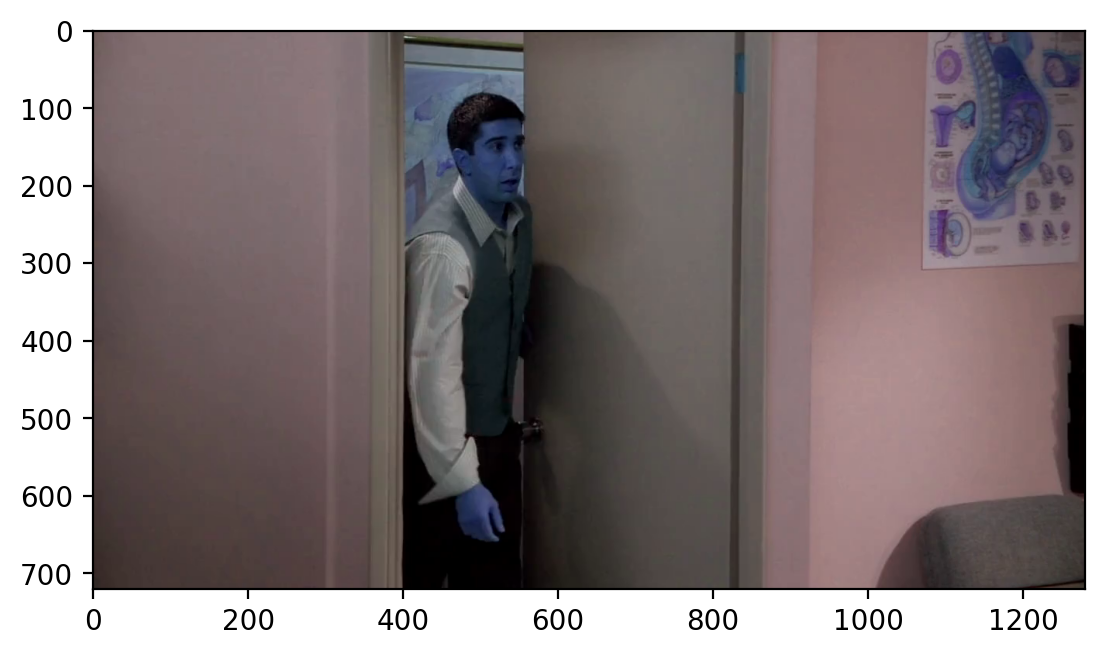

In [42]:
text_



Oh , look , wish me luck !


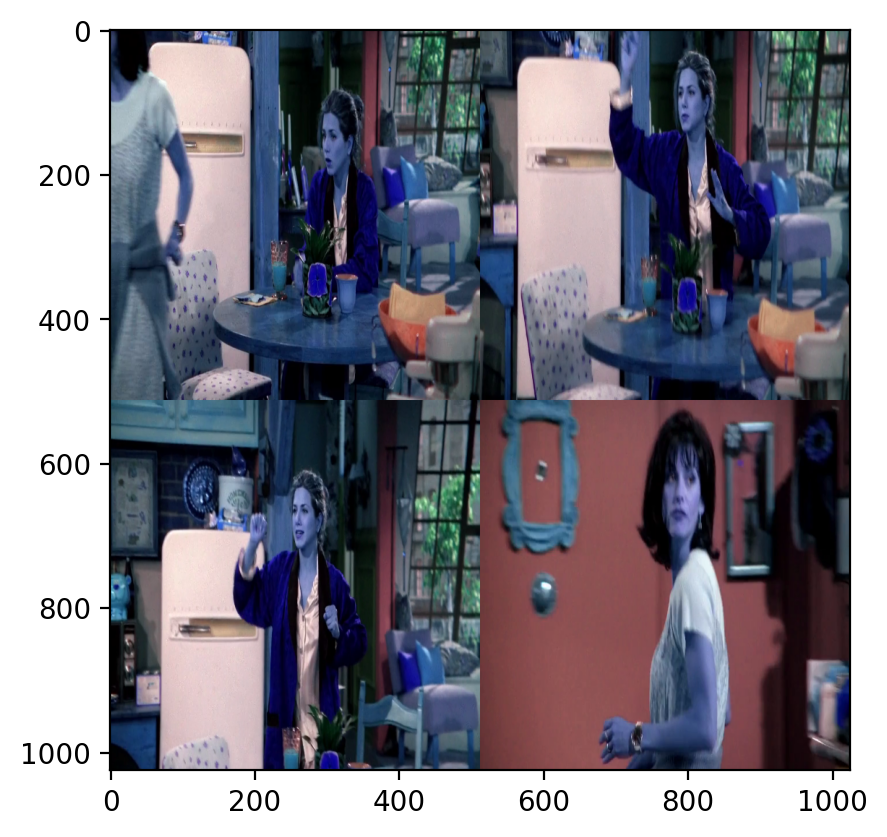

In [96]:
def get_comic_3(vid, axis=0, resize_n=224):
    comic_frames = [
        vid[0],  # start
        vid[len(vid)//2],
        vid[-1],  # end
    ]

    comic_frames = [cv2.resize(frame, (resize_n,resize_n)) for frame in comic_frames]

    if axis == 0:
        comic = np.zeros((resize_n*3, 224, 3), dtype=np.uint8)
        comic[:resize_n] = comic_frames[0]
        comic[resize_n:resize_n*2] = comic_frames[1]
        comic[resize_n*2:] = comic_frames[2]
    elif axis == 1:
        comic = np.zeros((resize_n, resize_n*3, 3), dtype=np.uint8)
        comic[:, :resize_n] = comic_frames[0]
        comic[:, resize_n:resize_n*2] = comic_frames[1]
        comic[:, resize_n*2:] = comic_frames[2]


    return comic

def get_comic_4(vid, resize_n=512):
    comic_frames = [
        vid[0],  # start
        vid[len(vid)//3],
        vid[len(vid)*2//3],
        vid[-1]  # end
    ]

    comic_frames = [cv2.resize(frame, (resize_n,resize_n)) for frame in comic_frames]

    comic = np.zeros((resize_n*2, resize_n*2, 3), dtype=np.uint8)
    comic[:resize_n, :resize_n] = comic_frames[0]
    comic[:resize_n, resize_n:] = comic_frames[1]
    comic[resize_n:, :resize_n] = comic_frames[2]
    comic[resize_n:, resize_n:] = comic_frames[3]

    return comic

vid, utt = load_utt(5, 1, text_data)

# comic = get_comic_3(vid, axis=0)
comic = get_comic_4(vid)
comic = frame_to_img(comic)

print(utt['text'])
plt.imshow(comic)
comic = preprocess(comic)

In [60]:
text_data[10]

{'conversation_ID': 11,
 'conversation': [{'utterance_ID': 1,
   'text': 'I mean , why should I let them meet him ? I mean , I bring a guy home , and within five minutes they are all over him . I mean , they are like ... coyotes , picking off the weak members of the herd .',
   'speaker': 'Monica',
   'emotion': 'disgust',
   'video_name': 'dia11utt1.mp4'},
  {'utterance_ID': 2,
   'text': 'Listen . As someone who seen more than her fair share of bad beef , I will tell you : that is not such a terrible thing .',
   'speaker': 'Paula',
   'emotion': 'neutral',
   'video_name': 'dia11utt2.mp4'},
  {'utterance_ID': 3,
   'text': 'Come on , they are your friends , they are just looking out after you .',
   'speaker': 'Paula',
   'emotion': 'neutral',
   'video_name': 'dia11utt3.mp4'},
  {'utterance_ID': 4,
   'text': 'I know . I just wish that once , I would bring a guy home that they actually liked .',
   'speaker': 'Monica',
   'emotion': 'sadness',
   'video_name': 'dia11utt4.mp4'},
  {

In [88]:
utt

{'utterance_ID': 1,
 'text': 'Oh , look , wish me luck !',
 'speaker': 'Rachel',
 'emotion': 'joy',
 'video_name': 'dia5utt1.mp4'}

In [97]:
original_images = []
images = []
texts = []
for conv_dict in text_data[:2]:
    c_i = conv_dict['conversation_ID']
    print(c_i)
    for utt_dict in conv_dict['conversation']:
        u_i = utt_dict['utterance_ID']

        vid, utt = load_utt(c_i, u_i, text_data)

        comic = get_comic_4(vid)
        comic = frame_to_img(comic)

        original_images.append(comic)
        images.append(preprocess(comic))
        texts.append(utt['text'])

1
2


## Building features

We normalize the images, tokenize each text input, and run the forward pass of the model to get the image and text features.

In [112]:
image_input = torch.tensor(np.stack(images)).cuda()
text_tokens = clip.tokenize(["" + desc for desc in texts]).cuda()

In [113]:
with torch.no_grad():
    image_features = model.encode_image(image_input).float()
    text_features = model.encode_text(text_tokens).float()

## Calculating cosine similarity

We normalize the features and calculate the dot product of each pair.

In [114]:
texts[-1]

'Rachel ? !'

In [ ]:
image_features /= image_features.norm(dim=-1, keepdim=True)
text_features /= text_features.norm(dim=-1, keepdim=True)
similarity = text_features.cpu().numpy() @ image_features.cpu().numpy().T

In [ ]:
text_features[0].shape

torch.Size([512])

Text(0.5, 1.0, 'Cosine similarity between text and image features\n representation: comic_4')

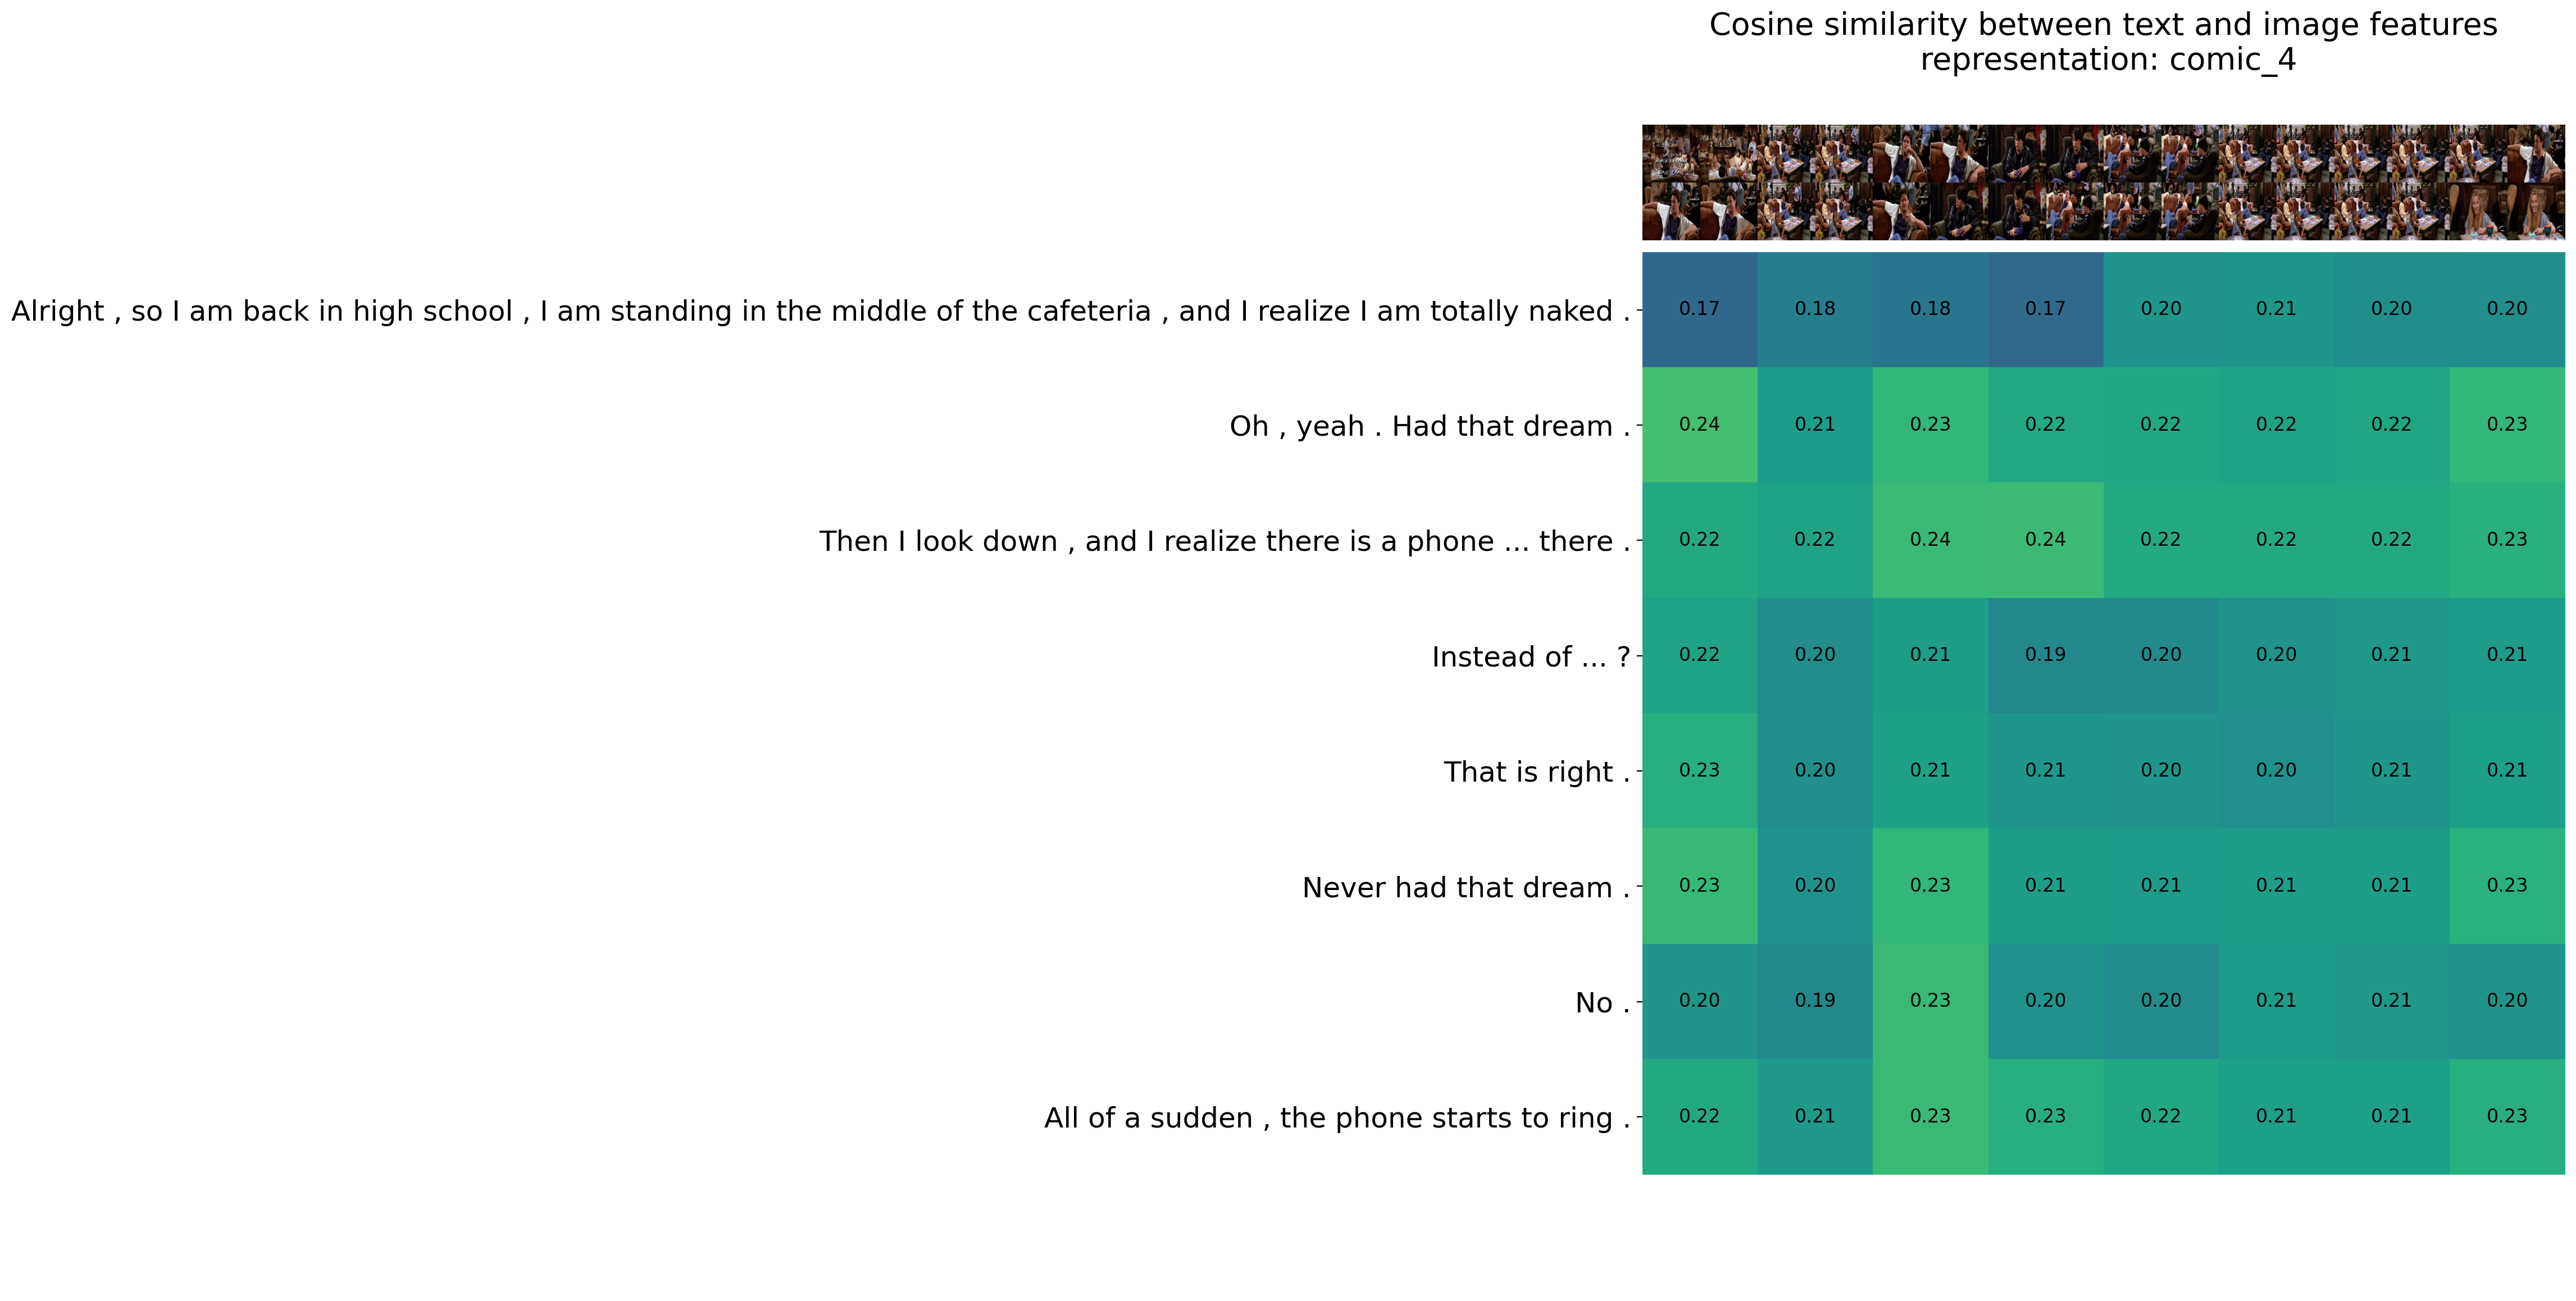

In [ ]:
count = len(texts)

plt.figure(figsize=(20, 14))
plt.imshow(similarity, vmin=0.1, vmax=0.3)
# plt.colorbar()
plt.yticks(range(count), texts, fontsize=18)
plt.xticks([])
for i, image in enumerate(original_images):
    # image = image.permute(1, 2, 0)
    plt.imshow(image, extent=(i - 0.5, i + 0.5, -1.6, -0.6), origin="lower")
for x in range(similarity.shape[1]):
    for y in range(similarity.shape[0]):
        plt.text(x, y, f"{similarity[y, x]:.2f}", ha="center", va="center", size=12)

for side in ["left", "top", "right", "bottom"]:
  plt.gca().spines[side].set_visible(False)

plt.xlim([-0.5, count - 0.5])
plt.ylim([count + 0.5, -2])

plt.title(f"Cosine similarity between text and image features\n representation: {frame_type}", size=20)

# Zero-Shot Image Classification

You can classify images using the cosine similarity (times 100) as the logits to the softmax operation.

In [ ]:
from torchvision.datasets import CIFAR100

cifar100 = CIFAR100(os.path.expanduser("~/.cache"), transform=preprocess, download=True)

100%|██████████| 169001437/169001437 [00:02<00:00, 79930858.99it/s]


Extracting /root/.cache/cifar-100-python.tar.gz to /root/.cache


In [ ]:
text_descriptions = [f"This is a photo of a {label}" for label in cifar100.classes]
text_tokens = clip.tokenize(text_descriptions).cuda()

In [ ]:
with torch.no_grad():
    text_features = model.encode_text(text_tokens).float()
    text_features /= text_features.norm(dim=-1, keepdim=True)

text_probs = (100.0 * image_features @ text_features.T).softmax(dim=-1)
top_probs, top_labels = text_probs.cpu().topk(5, dim=-1)

In [ ]:
plt.figure(figsize=(16, 16))

for i, image in enumerate(original_images):
    plt.subplot(4, 4, 2 * i + 1)
    plt.imshow(image)
    plt.axis("off")

    plt.subplot(4, 4, 2 * i + 2)
    y = np.arange(top_probs.shape[-1])
    plt.grid()
    plt.barh(y, top_probs[i])
    plt.gca().invert_yaxis()
    plt.gca().set_axisbelow(True)
    plt.yticks(y, [cifar100.classes[index] for index in top_labels[i].numpy()])
    plt.xlabel("probability")

plt.subplots_adjust(wspace=0.5)
plt.show()

Output hidden; open in https://colab.research.google.com to view.